This notebook is used to develop code for anomaly detection

# Library

In [123]:
# data processing and modeling libraries
import numpy as np
import pandas as pd

# data visualization libraries
import matplotlib.pyplot as plt
import plotly
import seaborn as sns

# other libraries
import csv
from datetime import datetime
import os
import re
import shutil

# Code

Load the anamoly data

In [124]:
df_basic_flow_meter_data = pd.read_csv('../dev_data/simulated_data_basic_flow_meter_20250219.csv', index_col=0 )
df_basic_flow_meter_data.index = pd.to_datetime(df_basic_flow_meter_data.index)

In [125]:
df_basic_flow_meter_data

,flow_rate
timestamp,
2024-01-01 00:00:00,89.480059
2024-01-01 00:05:00,145.479893
2024-01-01 00:10:00,126.553333
2024-01-01 00:15:00,80.167604
2024-01-01 00:20:00,93.858660
...,...
2024-01-07 22:15:00,119.502040
2024-01-07 22:20:00,88.690286
2024-01-07 22:25:00,92.226058


<Axes: xlabel='timestamp'>

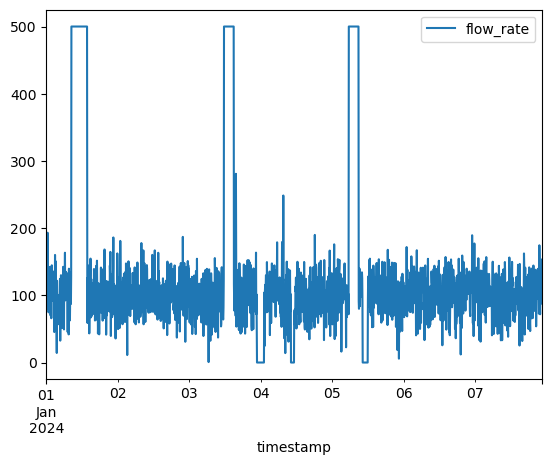

In [126]:
df_basic_flow_meter_data.plot()

#### DataFrame Checker

In [ ]:
#### Function not complete or Unit Tested
def dataFrame_checker(df: pd.DataFrame):
    """This function checks a dataframe format to ensure that it is set up properly before using it in outlier and anomaly detection functions.

    Args:
        df (pd.DataFrame): a dataframe that has a datetime index and data in the first column.

    Returns:
        The function returns a dictionary with a key as the component of the data frame and a value as a bool where is 1 is present and formatted correctly and 0 has an error
    """

#### Default Fail Min and Fail Max Analyzer

In [ ]:
###### Not Function Complete or Unit Tested ######

def fault_failure_min_max(df: pd.DataFrame, min_val: int = None, max_val: int = None, gen_val: int = None):
    """The function takes is dataframe that contains time series data where failure in a process may automatically default to a min or a max number. The function checks uses a deterministic analysis to check for the default values.

    Args:
        df (pd.DataFrame): a dataframe that contains time-series data for the index and univariate data in the first column.

        min_val (int, optional): A minimal value that a process may default to.  Any number equal to or less than min_val will be labeled as a fault value. Defaults to None.

        max_val (int, optional): A maximum value that a process may default to.  Any number equal to or greater than max_val will be labeled as a fault value. Defaults to None.

        gen_val (int, optional): A value, typically picked by a programmer, that a process may default to.  gen_number will be labeled as a fault value. Defaults to None.

    Returns:
        The function returns the dataframe with a column labeled "Faulted", with a bool where 1 for a faulted value or 0 for a non-fault value.

    Notes:
        Run this function prior to running though any outlier or anomaly detection function

    """
    # check for types errors for parameters
    if not isinstance(min_val, (int, type(None))):
        raise TypeError("failure_min_max: min_remove needs to be an integer or None value")

    if not isinstance(max_val, (int, type(None))):
        raise TypeError("failure_min_max: max_val needs to be an integer or None value.")

    if not isinstance(gen_val, (int, type(None))):
        raise TypeError("failure_min_max: gen_val needs to be an integer or None value.")

    #create a copy as to not change global df
    df_default=df.copy()

    # assume there are no values that default
    df_default['default_val'] = 0

    #select the first column name
    col = df_default.columns[0]

    # gen vs min/max

    if (max_remove is not None) and (min_remove is None):
        df_remove = df[df[col] >= max_remove]

    if (max_remove is None) and (min_remove is not None):
        df_remove = df[df[col] <= min_remove]

    if ((max_remove is not None) and (min_remove is not None)):
        df_remove_min = df[df[col] <= min_remove]
        df_remove_max = df[df[col] >= max_remove]
        df_remove = pd.concat((df_remove_max, df_remove_min))
    df_remove = df_remove.copy()
    df_remove['outlier'] = 0

    return df_default


In [136]:
fault_failure_min_max(df=df_basic_flow_meter_data)

                      flow_rate  default_val
timestamp                                   
2024-01-01 00:00:00   89.480059            0
2024-01-01 00:05:00  145.479893            0
2024-01-01 00:10:00  126.553333            0
2024-01-01 00:15:00   80.167604            0
2024-01-01 00:20:00   93.858660            0
...                         ...          ...
2024-01-07 22:15:00  119.502040            0
2024-01-07 22:20:00   88.690286            0
2024-01-07 22:25:00   92.226058            0
2024-01-07 22:30:00  153.713038            0
2024-01-07 22:35:00   87.690843            0

[2000 rows x 2 columns]


## IQR Outlier Detection

In [ ]:
#remove min_remove and max_remove as this will be made into its own definition

def IQR_outlier(df: pd.DataFrame, min_remove=None, max_remove=None):
    """
    The IQR is the interquartile range that will be used for outlier detection.  This function will work with the IQR for univariate time-series data.

    The function also has the option to have it ignore values if the fault to an defined value.  This is common for process instrumentation to fail to a specific value when shutoff or during a fault situation.

    Parameters
    ----------
    df (pd.DataFrame): a dataframe that contains time-series data for the index and univariate data in the first column.

    max_remove (int, float, optional): A default failure value that goes to a numeric value typically higher than than the operational range for the data.  This should be excluded from the outlier analysis. Default is none.

    min_remove (int, float, optional): A default failure value that goes to a numeric value typically lower than than the operational range for the data.This should be excluded from the outlier analysis.

    Notes
    -----

    Returns
    -------
    The function will return cleaned time-series data

    """
    #create a copy as to not change global df
    df=df.copy()

    # check for types errors for parameters
    if not isinstance(min_remove, (int, float, type(None))):
        raise TypeError("min_remove needs to be an integer or float value")

    if not isinstance(max_remove, (int, float, type(None))):
        raise TypeError("max_remove needs to be an integer or float.")


    #Find rows in df that are not in df_remove
    df_diff = df[~df[col].isin(df_remove[col])].copy()

    # Calculate the IQR for df_diff
    q1 = df_diff[col].quantile(q=0.25)
    q3 = df_diff[col].quantile(q=0.75)
    IQR = q3 - q1

    #Calculate lower and upper bounds for outliers
    lower_bound = q1 - (1.5 * IQR)
    upper_bound = q3 + (1.5 * IQR)

    #Find outliers
    df_diff['outlier'] = df_diff[col].apply(lambda x: 1 if (x < lower_bound) or (x > upper_bound) else 0)
    
    df = pd.concat((df_diff, df_remove))
    df = df.sort_index()

    return df


In [119]:
a = IQR_outlier(df = df_basic_flow_meter_data, min_remove=0, max_remove=500)

In [120]:
#there are 207 rows in the min_remove and max_remove.
a.shape

(2000, 2)

In [121]:
len(a[a['outlier']==1])

17

In [122]:
a.to_csv("..\\dev_data\\iqr_results.csv")

# If they are not filled out, they still need to be completed.  These are just suggested ideas right now

## Mahalanobius Filter

## Hampel Filter

A Hampel filter uses median absolute deviation (MAD) and rolling window to detect outliers in a time series graph.



In [ ]:
def hampel_filter(df: pd.DataFrame, window_k: int = 5, distribution: str = 'Normal'):
    """
    This function runs a Hampel filter over time series data to find outliers.  The Hampel filter uses a rolling window

    Args:
        df (pd.DataFrame): a dataframe that contains time-series data.  The index required a DateTime format and numeric data in the first column.

        window_k (int): A positive integer that represents the k neighbors on either side of the data point being analyzed.  It is used to build the window size.  window = 2k+1

        distribution (str, optional): The type of distribution curve that is being analyzed by the Hampel filter.  Select from Normal, Uniform, LaPlacian, Exponential. Defaults to 'Normal'.
    """
    # create dictionary for distributions.  The key is the distribution.  The value is MAD Scaling Factor for different distributions
    dict_distr = {
        "Normal": 1.4826,
        "Uniform": 1.16,
        "LaPlacian": 2.04,
        "Exponential":2.08}

    #check the integrity parameters
    try:
        #check df is dataframe
        if isinstance(df, (pd.DataFrame)):
            #check the index and column types
            if isinstance(df.index, pd.core.indexes.datetimes.DatetimeIndex)  and pd.api.types.is_numeric_dtype(df.iloc[:,0]):
                #create a working copy of df for inside function
                df_inside = df.copy()
            else:
                raise AssertionError("hampel_filter: Dataframe needs a DateTime index and a numeric value in the first column")
    except:
        raise TypeError("hampel_filter: df parameter is not formatted correctly")

    if not isinstance(window_k, int):
        raise TypeError("hamppel_filter: window_k needs to be an int")

    if not isinstance(distribution, str):
        raise TypeError("hampel_filter: distribution needs to be a string.")

    if distribution not in ("Normal", "Uniform", "LaPlacian", "Exponential"):
        raise ValueError("hampel_filter: select the correct type of distribution")

    window = 2 * window_k + 1  ################## Ended Here - not  complete ##########



In [ ]:
hampel_filter(df=df_basic_flow_meter_data, window_k=5, distribution= "Normal")

## Isolation Forest

## Jenson Shannon

## Kalman filter

## LSTM AutoEncoder for Anomaly Detection